In [9]:
import os.path
import pickle
import random

from wbtools.lib.nlp.text_preprocessing import get_documents_from_text
from sentence_transformers import SentenceTransformer, util
from matplotlib import pyplot as plt
import numpy as np
import random
import umap
from scipy import spatial

import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

## Define constants

In [10]:
min_sentence_length = 50
max_corpus_size = 10000
use_cached_embeddings = False
bio_sent_vec_model_location = "../biosentvec/model.bin"

## Read positive and negative sentences from file

In [11]:
def read_positive_sentences_from_file(filepath, min_sent_length=20):
    return [sentence for line in open(filepath) for sentence in get_documents_from_text(
        text=line.strip(), split_sentences=True) if len(sentence) > min_sent_length]

sent_expr_pattern = read_positive_sentences_from_file("../extracted_sentences/sentences_exp_pattern.txt",
                                                      min_sentence_length)
sent_subcellloc = read_positive_sentences_from_file("../extracted_sentences/sentences_exp_subcellloc.txt",
                                                    min_sentence_length)
neg_sent_otherexpr = [sent for sent in open("../extracted_sentences/neg_sentences_otherexpr.txt") if len(sent) >
                      min_sentence_length]

## Clean sentences

In [12]:
def clean_sentences(sentences):
    stop_words = set(stopwords.words('english'))
    ret_sent = []
    for sentence in sentences:
        sentence = sentence.replace('/', ' / ')
        sentence = sentence.replace('.-', ' .- ')
        sentence = sentence.replace('.', ' . ')
        sentence = sentence.replace('\'', ' \' ')
        tokens = [token for token in word_tokenize(sentence) if token not in punctuation and token not in stop_words]
        sentence = ' '.join(tokens)
        ret_sent.append(sentence)
    return list(set([sent.strip(' ').strip('.;,/-|').strip() for sent in ret_sent]))

sent_expr_pattern_clean = clean_sentences(sent_expr_pattern)
sent_subcellloc_clean = clean_sentences(sent_subcellloc)
neg_sent_otherxpr_clean = clean_sentences(neg_sent_otherexpr)

## Sample sentences

In [13]:
def get_random_sentence_subset(sentences, max_num_sentences):
    corpus = sentences
    random.shuffle(corpus)
    return corpus[0:max_num_sentences]

if use_cached_embeddings and os.path.exists("../sentence_embeddings/corpus_expr_pattern.txt") and os.path.exists("../sentence_embeddings/corpus_subcellloc.txt") and os.path.exists("../sentence_embeddings/corpus_neg_otherexpr.txt"):
    corpus_expr_pattern = [line.strip() for line in open("../sentence_embeddings/corpus_expr_pattern.txt")]
    corpus_expr_subcellloc = [line.strip() for line in open("../sentence_embeddings/corpus_subcellloc.txt")]
    corpus_neg_otherexpr = [line.strip() for line in open("../sentence_embeddings/corpus_neg_otherexpr.txt")]
else:
    corpus_expr_pattern = get_random_sentence_subset(sent_expr_pattern_clean, max_corpus_size)
    corpus_expr_subcellloc = get_random_sentence_subset(sent_subcellloc_clean, max_corpus_size)
    corpus_neg_otherexpr = get_random_sentence_subset(neg_sent_otherxpr_clean, max_corpus_size)
    with open("../sentence_embeddings/corpus_expr_pattern.txt", "w") as corpus_expr_pattern_file:
        for sent in corpus_expr_pattern:
            corpus_expr_pattern_file.write(sent + "\n")
    with open("../sentence_embeddings/corpus_subcellloc.txt", "w") as corpus_expr_subcellloc_file:
        for sent in corpus_expr_subcellloc:
            corpus_expr_subcellloc_file.write("sent" + "\n")
    with open("../sentence_embeddings/corpus_neg_otherexpr.txt", "w") as corpus_neg_otherexpr_file:
        for sent in corpus_neg_otherexpr:
            corpus_neg_otherexpr_file.write("sent" + "\n")

## Extract sentence embeddings with SBERT

In [14]:
if use_cached_embeddings and os.path.exists("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle") and os.path.exists("../sentence_embeddings/corpus_embeddings_subcellloc.pickle") and os.path.exists("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle"):
    corpus_embeddings_expr_pattern = pickle.load(open("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle", "rb"))
    corpus_embeddings_subcellloc = pickle.load(open("../sentence_embeddings/corpus_embeddings_subcellloc.pickle", "rb"))
    corpus_embeddings_neg_otherexpr = pickle.load(open("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle", "rb"))
else:
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    corpus_embeddings_expr_pattern = embedder.encode(corpus_expr_pattern, convert_to_tensor=True)
    corpus_embeddings_subcellloc = embedder.encode(corpus_expr_subcellloc, convert_to_tensor=True)
    corpus_embeddings_neg_otherexpr = embedder.encode(corpus_neg_otherexpr, convert_to_tensor=True)
    pickle.dump(corpus_embeddings_expr_pattern, open("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle", "wb"))
    pickle.dump(corpus_embeddings_subcellloc, open("../sentence_embeddings/corpus_embeddings_subcellloc.pickle", "wb"))
    pickle.dump(corpus_embeddings_neg_otherexpr, open("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle", "wb"))

## Use UMAP to obtain a dataset that can be visualized in 2d

In [15]:
umap_reducer = umap.UMAP(metric='cosine')
corpus_embeddings_expr_pattern_2d = umap_reducer.fit_transform(corpus_embeddings_expr_pattern)
corpus_embeddings_subcellloc_2d = umap_reducer.fit_transform(corpus_embeddings_subcellloc)
corpus_embeddings_neg_otherexpr_2d = umap_reducer.fit_transform(corpus_embeddings_neg_otherexpr)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
colors = ['g'] * len(corpus_embeddings_expr_pattern_2d) + ['y'] * len(corpus_embeddings_subcellloc_2d) + ['b'] * len(corpus_embeddings_neg_otherexpr_2d)

In [17]:
all_corpora_2d = np.vstack((corpus_embeddings_expr_pattern_2d, corpus_embeddings_subcellloc_2d, corpus_embeddings_neg_otherexpr_2d))

## UMAP visualization with different colors for each sentence category
- expr_pattern = green
- subcellloc = yellow
- negative = blue

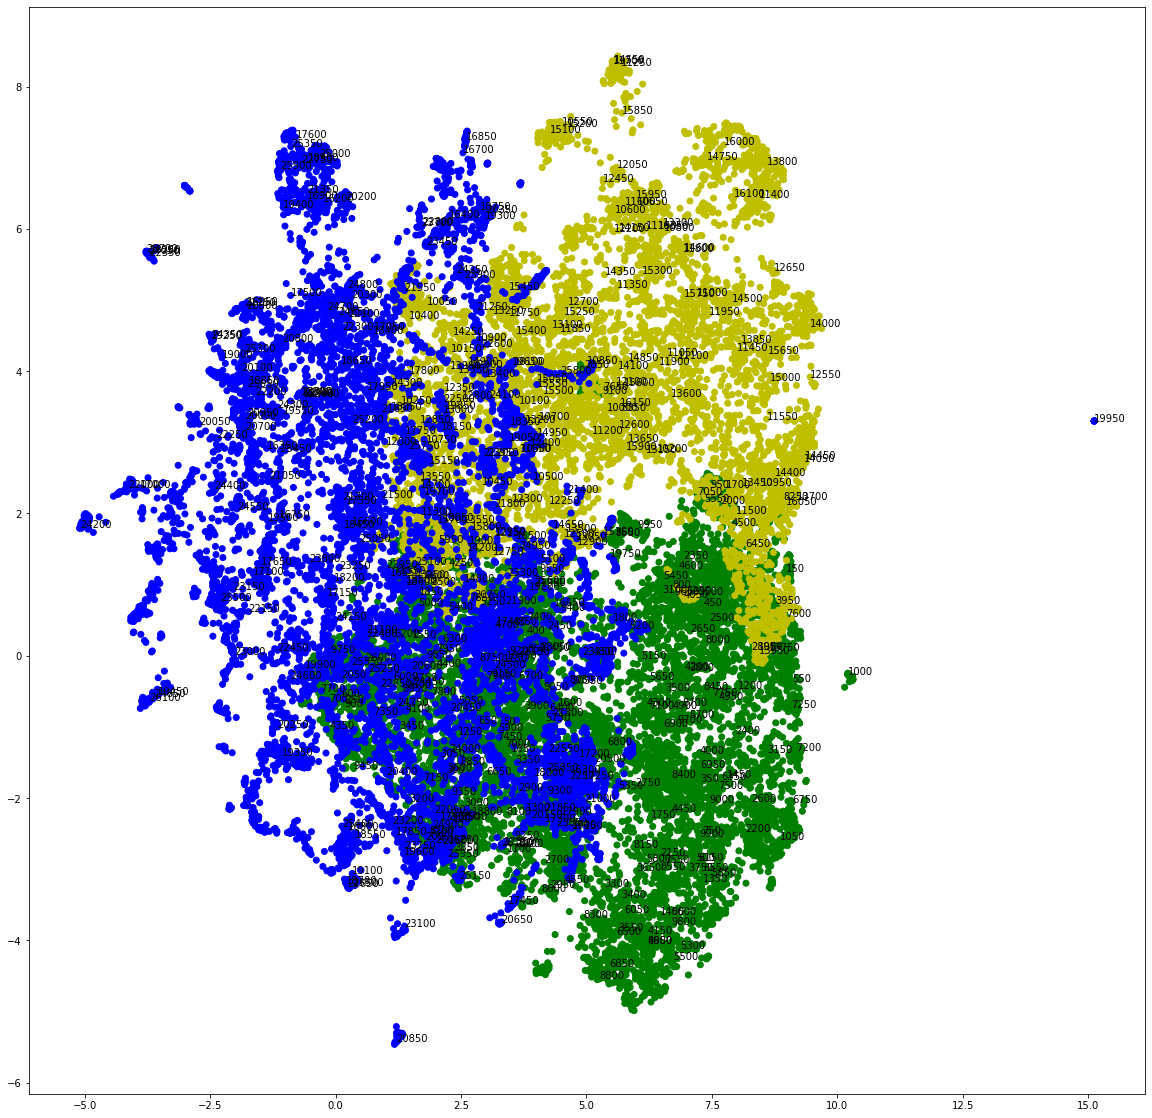

In [18]:
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(all_corpora_2d[:,0]), y=list(all_corpora_2d[:,1]), c=colors)
for i in range(len(all_corpora_2d)):
    if i % 50 == 0:
        plt.annotate(str(i), (all_corpora_2d[i,0], all_corpora_2d[i,1]))

In [19]:
best_matches = util.semantic_search(query_embeddings=corpus_embeddings_neg_otherexpr, corpus_embeddings=corpus_embeddings_expr_pattern)

In [20]:
[(i, corpus_id_score_dict) for i, values in enumerate(best_matches) for corpus_id_score_dict in values if corpus_id_score_dict['score'] > 0.8]

[]

In [21]:
1 - spatial.distance.cosine(corpus_embeddings_neg_otherexpr[394], corpus_embeddings_expr_pattern[2208])

0.1053241565823555

# Extract sentence embeddings with BioSentVec

In [22]:
model_path = bio_sent_vec_model_location
biosentvec_model = sent2vec.Sent2vecModel()
try:
    biosentvec_model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [23]:
corpus_embeddings_expr_pattern_bio = biosentvec_model.embed_sentences(corpus_expr_pattern)
corpus_embeddings_subcellloc_bio = biosentvec_model.embed_sentences(corpus_expr_subcellloc)
corpus_embeddings_neg_otherexpr_bio = biosentvec_model.embed_sentences(corpus_neg_otherexpr)

In [24]:
umap_reducer = umap.UMAP(metric='cosine')
corpus_embeddings_expr_pattern_bio_2d = umap_reducer.fit_transform(corpus_embeddings_expr_pattern_bio)
corpus_embeddings_subcellloc_bio_2d = umap_reducer.fit_transform(corpus_embeddings_subcellloc_bio)
corpus_embeddings_neg_otherexpr_bio_2d = umap_reducer.fit_transform(corpus_embeddings_neg_otherexpr_bio)

In [25]:
all_corpora_bio_2d = np.vstack((corpus_embeddings_expr_pattern_bio_2d, corpus_embeddings_subcellloc_bio_2d, corpus_embeddings_neg_otherexpr_bio_2d))

## UMAP visualization
- expr_pattern = green
- subcellloc = yellow
- negative = blue

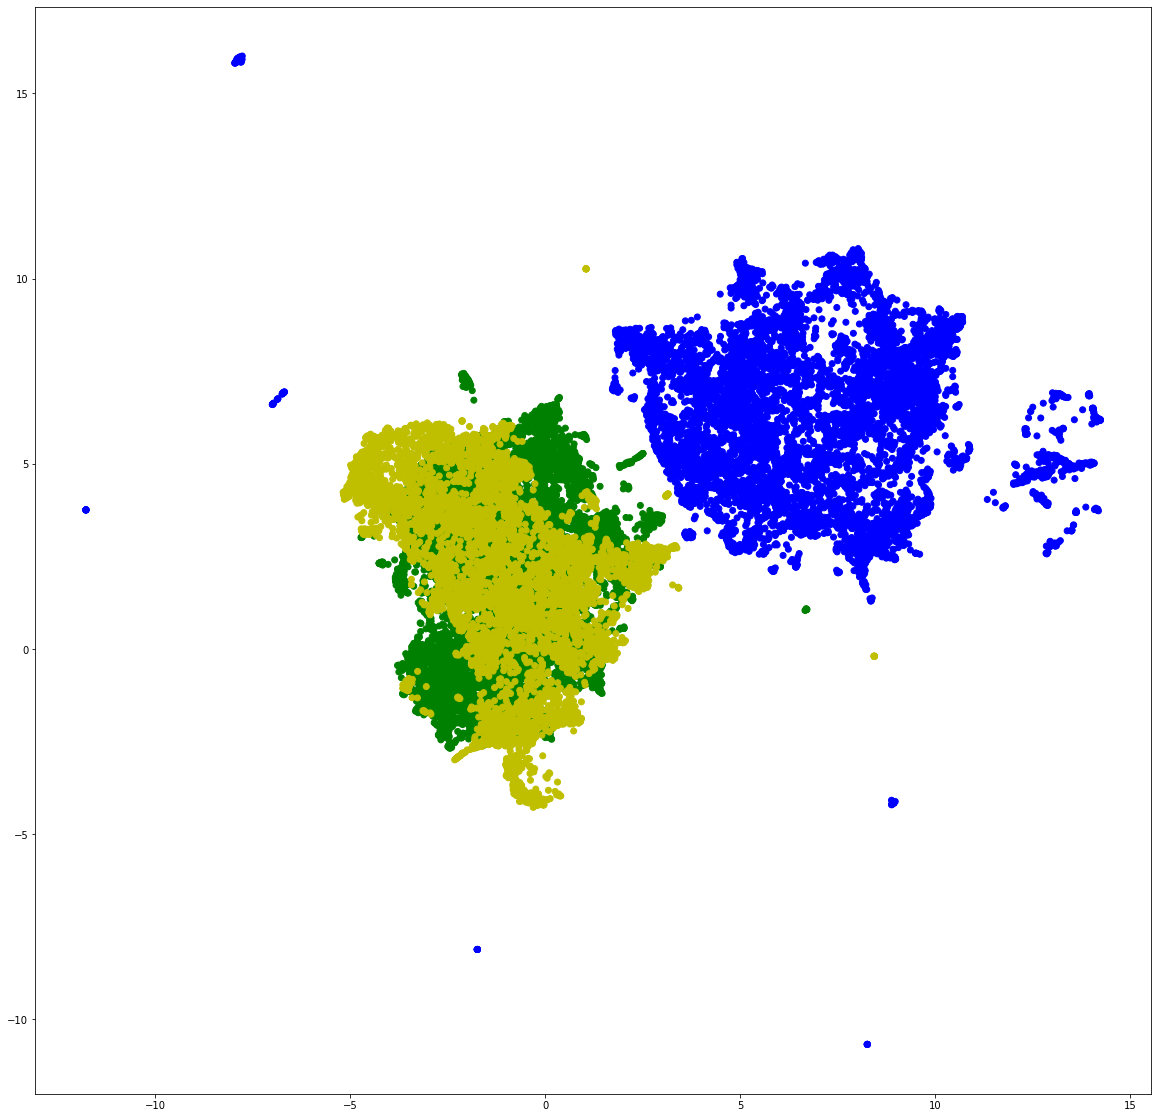

In [26]:
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(all_corpora_bio_2d[:,0]), y=list(all_corpora_bio_2d[:,1]), c=colors)

In [27]:
best_matches_bio = util.semantic_search(query_embeddings=corpus_embeddings_neg_otherexpr_bio, corpus_embeddings=corpus_embeddings_expr_pattern_bio)

In [31]:
[(i, corpus_id_score_dict) for i, values in enumerate(best_matches_bio) for corpus_id_score_dict in values if corpus_id_score_dict['score'] > 0.8 and corpus_id_score_dict['corpus_id'] != i][0:10]

[(130, {'corpus_id': 7096, 'score': 0.8995802998542786}),
 (130, {'corpus_id': 3919, 'score': 0.8834688663482666}),
 (130, {'corpus_id': 8437, 'score': 0.864872395992279}),
 (144, {'corpus_id': 7096, 'score': 0.8967962861061096}),
 (144, {'corpus_id': 3919, 'score': 0.8812562227249146}),
 (144, {'corpus_id': 8437, 'score': 0.8633268475532532}),
 (172, {'corpus_id': 7096, 'score': 0.9023388624191284}),
 (172, {'corpus_id': 3919, 'score': 0.8662940263748169}),
 (172, {'corpus_id': 8437, 'score': 0.8500856161117554}),
 (520, {'corpus_id': 7096, 'score': 0.8950433731079102})]

In [36]:
corpus_expr_pattern[7096]

'AFD 100 AVK 87 DVA 83 NSM 22 M5 16 RIC AIZ'

In [35]:
corpus_neg_otherexpr[520]

'13C NMR DMSO-d6 168 01 163 53 159 50 151 74 147 52 131 97 131 73 126 51 125 84 92 61 80 15 42 69 31 43 29 95 24 68 18 05 17 52 13 33 HRMS EI z 405 1993 M calc'

In [45]:
centroid_exp_pattern_embeddings_bio = np.average(corpus_embeddings_expr_pattern_bio, 0)
centroid_subcellloc_embeddings_bio = np.average(corpus_embeddings_subcellloc_bio, 0)

## Classification accuracy

In [156]:
def get_stats(cosine_sim_thr, centroid_positive, embeddings_positive, embeddings_negative):
    tp = len([(i, c) for i in range(len(embeddings_positive)) if (c := (1 - spatial.distance.cosine(centroid_positive, embeddings_positive[i]))) > cosine_sim_thr and not all(embeddings_positive[i] == 0)])
    fn = len(embeddings_positive) - tp
    fp = len([(i, c) for i in range(len(embeddings_negative)) if (c := (1 - spatial.distance.cosine(centroid_positive, embeddings_negative[i]))) > cosine_sim_thr and not all(embeddings_negative[i] == 0)])
    tn = len(embeddings_negative) - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return f1, precision, recall, tpr, fpr

In [157]:
stats_expr_pattern_list = [get_stats(i, centroid_exp_pattern_embeddings_bio, corpus_embeddings_expr_pattern_bio, corpus_embeddings_neg_otherexpr_bio) for i in [elem + 0.3 + i/100 for i, elem in enumerate([0] * 30)]]
stats_subcellloc_list = [get_stats(i, centroid_subcellloc_embeddings_bio, corpus_embeddings_subcellloc_bio, corpus_embeddings_neg_otherexpr_bio) for i in [elem + 0.3 + i/100 for i, elem in enumerate([0] * 30)]]

## F1 measure analysis
### Expression Pattern

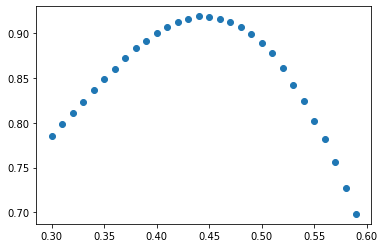

In [158]:
plt.scatter([elem + 0.3 + i/100 for i, elem in enumerate([0] * 30)], [stat[0] for stat in stats_expr_pattern_list])

### Subcellular localization

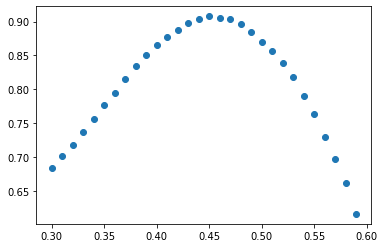

In [159]:
plt.scatter([elem + 0.3 + i/100 for i, elem in enumerate([0] * 30)], [stat[0] for stat in stats_subcellloc_list])

## Precision and recall of best threshold
### Expression Pattern

In [160]:
print("Exp Pattern precision: " + str(get_stats(0.45, centroid_exp_pattern_embeddings_bio, corpus_embeddings_expr_pattern_bio, corpus_embeddings_neg_otherexpr_bio)[1]))
print("Exp pattern recall: " + str(get_stats(0.45, centroid_exp_pattern_embeddings_bio, corpus_embeddings_expr_pattern_bio, corpus_embeddings_neg_otherexpr_bio)[2]))

Exp Pattern precision: 0.9323711340206186
Exp pattern recall: 0.9044


### Subcellular localization

In [161]:
print("Subcellular localization precision: " + str(get_stats(0.45, centroid_subcellloc_embeddings_bio, corpus_embeddings_subcellloc_bio, corpus_embeddings_neg_otherexpr_bio)[1]))
print("Subcellular localization recall: " + str(get_stats(0.45, centroid_subcellloc_embeddings_bio, corpus_embeddings_subcellloc_bio, corpus_embeddings_neg_otherexpr_bio)[2]))

Subcellular localization precision: 0.9153517422748192
Subcellular localization recall: 0.9004042037186742


## ROC
### Exp pattern

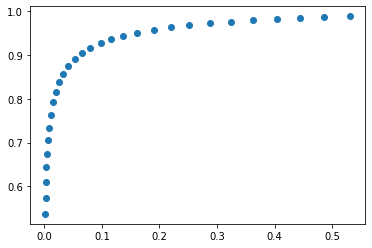

In [162]:
plt.scatter([stat[4] for stat in stats_expr_pattern_list], [stat[3] for stat in stats_expr_pattern_list])

### Subcell localization

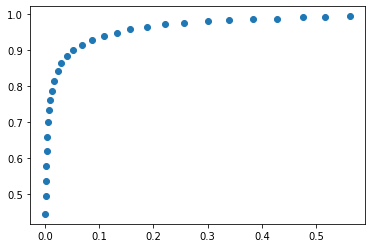

In [164]:
plt.scatter([stat[4] for stat in stats_subcellloc_list], [stat[3] for stat in stats_subcellloc_list])